# Lyric Generation Training Using GPT2

This notebook uses the data fetched from the Genius lyrics API in the other notebook from this repository to finetune a GPT2 model to generate lyrics.

This process is very computational intensive, it took me over 50 hours to train on a M1 Apple Macbook. For that same reason, the outputs in this notebook may not accurately reflect the training process.

Credit to [Ruben Winastwan](https://towardsdatascience.com/text-generation-with-gpt-092db8205cad) for his amazing article on fine-tuning GPT models which inspired the code in this notebook.

## Preliminaries

First I import the data and set up the device's GPU. I strongly suggest not running the code if you do not have a GPU.

In [1]:
import torch
import numpy as np
from torch import nn
from transformers import GPT2Tokenizer, GPT2Config, GPT2Model, GPT2PreTrainedModel
from torch.optim import AdamW
from datasets import load_dataset
from tqdm import tqdm
from torch.nn import functional as F
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_built() else 'cpu'

/Users/selbl/anaconda3/envs/CS129/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the dataset. The csv in the repository has two columns with lyrics: lyrics and lyrics cleaned (the formatted lyrics). In this notebook I only use the formatted lyrics, so I overwrite the original lyrics to train the model

In [2]:
#Load dataset
dataset = pd.read_csv('7000SongsDFCleanedLyricsParts.csv',index_col=False)
#Flip from cleaned to lyrics
dataset['Lyrics'] = dataset['Lyrics_Cleaned']

In [5]:
#Remove the nan
dataset = dataset.dropna()

So that the code knows where each phrase is supposed to end, I add a token to every song lyric.

In [25]:
#Add the end of text token at the end
dataset['Lyrics'] = [lyrics + ' <|endoftext|>' for lyrics in dataset['Lyrics']]

/var/folders/vx/3cyjfsr546x_wkrs920k2n2m0000gn/T/ipykernel_16731/2484988339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Lyrics'] = [lyrics + ' <|endoftext|>' for lyrics in dataset['Lyrics']]


## Tokenization

Having imported the data, I tokenize it so the model can properly operate. I also add a padding character so the lyrics have the same length.

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', pad_token='<|pad|>') 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
class GPT2_Model(GPT2PreTrainedModel):

    def __init__(self, config):

        super().__init__(config)

        self.transformer = GPT2Model.from_pretrained('gpt2')
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2', pad_token='<|pad|>')

        # this is necessary since we add a new unique token for pad_token
        self.transformer.resize_token_embeddings(len(tokenizer))

        self.lm_head = nn.Linear(config.n_embd, len(tokenizer), bias=False)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):

        x = self.transformer(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
        x = self.lm_head(x)

        return x

Obtain the text corpus from the lyrics. Also tokenize the input text.

In [8]:
#Get text corpus
text_corpus = [f"{txt} " for i, txt in enumerate(dataset['Lyrics']) if txt != '']
#get the tokenized input text
tokenized_inp_len = [len(tokenizer(txt,truncation=True)['input_ids']) for txt in text_corpus]

To get an idea of how the songs have different distributions of token lengths, I plot a histogram of the token lengths

Text(0.5, 0, 'Token Length')

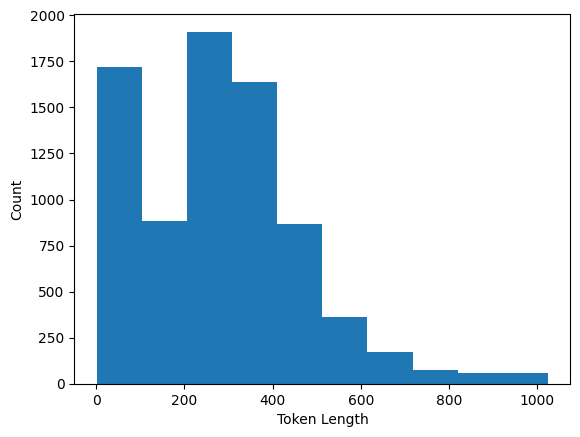

In [10]:
#Visualize distribution
x = np.asarray(tokenized_inp_len)
plt.hist(x, density=False, bins=10)  
plt.ylabel('Count')
plt.xlabel('Token Length')

The above histogram shows a bimodal distribution. I set the max length of the tokens in the model at 400 to account for that second peak.

In [11]:
#Set max length at 400 because of the above histogram
class LyricsDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, tokenizer, gpt2_type="gpt2", max_length=400):

        self.texts = [tokenizer(data, truncation=True, max_length=max_length, padding="max_length", return_tensors="pt")
                        for data in input_data]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

Define loss function and training functions

In [12]:
class CrossEntropyLossFunction(nn.Module):

    def __init__(self):

        super(CrossEntropyLossFunction, self).__init__()
        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, lm_logits, labels):

        shift_logits = lm_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()

        loss = self.loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        return loss

In [13]:
def train(model, tokenizer, train_data, epochs, learning_rate, epsilon=1e-8):

    train = LyricsDataset(train_data, tokenizer)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)

    optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
    criterion = CrossEntropyLossFunction().to(device)
    model = model.to(device)

    best_loss = 1000

    for epoch_i in range(0, epochs):

        total_train_loss = 0
        total_val_loss = 0
        for train_input in tqdm(train_dataloader):

            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].to(device)

            outputs = model(input_id,
                            attention_mask = mask,
                            token_type_ids=None
                            )

            loss = criterion(outputs, input_id)

            batch_loss = loss.item()
            total_train_loss += batch_loss

            loss.backward()
            optimizer.step()
            model.zero_grad()

        avg_train_loss = total_train_loss / len(train_dataloader)

        print(f"Epoch: {epoch_i}, Avg train loss: {np.round(avg_train_loss,2)}")

Having done that, it's time for training! Because the training took so long I did a few epochs at a time. You can save the results from your model and then load them again using the load_state_dict and save functions.

In [19]:
#Specify parameters and set up model
epochs = 10
learning_rate = 1e-5
configuration = GPT2Config()
gpt_model = GPT2_Model(configuration).to(device)
#Load model state if you want
gpt_model.load_state_dict(torch.load('GPT-Trained-Model'))
#Train
train(gpt_model, tokenizer, text_corpus, epochs, learning_rate)
#Save
torch.save(gpt_model.state_dict(), 'GPT-Trained-Model')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 3871/3871 [1:11:14<00:00,  1.10s/it]


Epoch: 0, Avg train loss: 0.67


100%|██████████| 3871/3871 [1:11:13<00:00,  1.10s/it]


Epoch: 1, Avg train loss: 0.6


100%|██████████| 3871/3871 [1:10:56<00:00,  1.10s/it]


Epoch: 2, Avg train loss: 0.54


100%|██████████| 3871/3871 [1:10:55<00:00,  1.10s/it]


Epoch: 3, Avg train loss: 0.48


100%|██████████| 3871/3871 [1:10:55<00:00,  1.10s/it]


Epoch: 4, Avg train loss: 0.42


100%|██████████| 3871/3871 [1:10:55<00:00,  1.10s/it]


Epoch: 5, Avg train loss: 0.37


100%|██████████| 3871/3871 [1:10:55<00:00,  1.10s/it]


Epoch: 6, Avg train loss: 0.33


100%|██████████| 3871/3871 [1:10:55<00:00,  1.10s/it]


Epoch: 7, Avg train loss: 0.28


100%|██████████| 3871/3871 [1:10:54<00:00,  1.10s/it]


Epoch: 8, Avg train loss: 0.25


100%|██████████| 3871/3871 [1:11:02<00:00,  1.10s/it]


Epoch: 9, Avg train loss: 0.21


After training the model, it's time to generate some lyrics! Refer to the following notebook to check the procedure.